### Prisma Data Analysis

Table of contents: 

  1. Importing librairies
  2. Defining functions
  3. Collecting data from file
  4. Plotting RGB
  5. Creating Pandas Geodataframe
  6. Importing Tare data


##### 1. Importing librairies

In [1]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.ops import unary_union

##### 2. Defining functions

In [2]:
def normalise(pic):
    max = pic.max()
    min = pic.min()
    new = (pic - min)/(max-min)
    return new

def create_geopandas(data_with_coord):
    columns = [f"band_{i}" for i in range(66)]
    columns.append("lat")
    columns.append("lon")
    data_with_coord_flat = data_with_coord.reshape(data_with_coord.shape[0]*data_with_coord.shape[1], 68)
    data = pd.DataFrame(data_with_coord_flat, columns=columns)
    df_all = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.lon, data.lat))
    return df_all


##### 3. Collecting data from file

In [3]:
filename = "..\data\[62.2287, 4.95679 ].he5"
data = None
with h5py.File(filename, mode='r') as f:
    data = np.array(f["HDFEOS"]["SWATHS"]["PRS_L1_HRC"]["Data Fields"]['VNIR_Cube'])
    lat = np.array(f["HDFEOS"]["SWATHS"]["PRS_L1_HRC"]['Geolocation Fields']['Latitude_VNIR'])
    lon = np.array(f["HDFEOS"]["SWATHS"]["PRS_L1_HRC"]['Geolocation Fields']['Longitude_VNIR'])

#####   3.2 Importing Tare data

In [4]:
data_naturdirektoratet = gpd.read_file("../data/naturdirektoratet.json")
seaweed = data_naturdirektoratet.copy()
seaweed= seaweed.loc[seaweed["naturtype"] == "størreTareskogforekomster"]

##### 3.5 Combining data with coordinates (Lat/Lon)

In [5]:
coord = np.array([lat,lon]).T
data_with_coord = np.zeros((1000,1000,66+2))
data_with_coord[:,:,:66] = np.transpose(data,[0,2,1])
data_with_coord[:,:,66:] = coord

##### 4. Plotting RGB

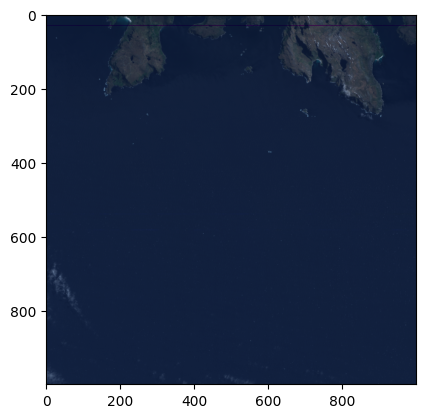

In [6]:
RGB = np.dstack((data_with_coord[:,:,33] , data_with_coord[:,:,45] , data_with_coord[:,:,56]))
RGB = normalise(RGB) 
plt.imshow(RGB)

##### 5. Creating Pandas

In [7]:
df_all = create_geopandas(data_with_coord)
df_all["seaweed"] = np.zeros(1000000)

##### 5.5 Plotting all the datapoints from the prisma and comparing to the seaweed data from naturdirektoratet.  
It looks correct.

In [8]:
lon_min, lat_min, lon_max, lat_max = df_all.total_bounds
seaweed = seaweed.cx[lon_min:lon_max, lat_min:lat_max]

<AxesSubplot:>

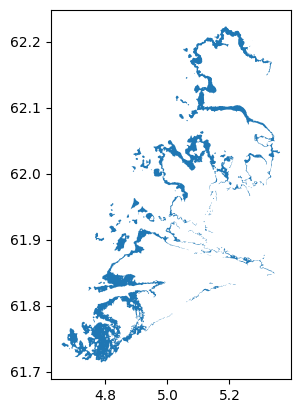

In [9]:
seaweed.plot()

<AxesSubplot:>

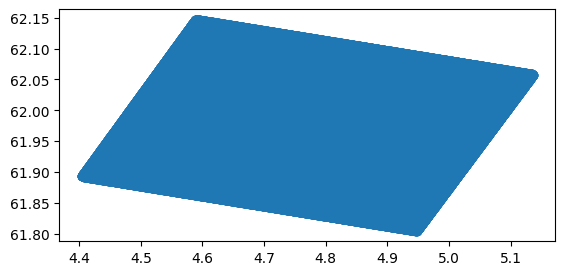

In [59]:
df_all.plot()

##### 7. Collecting training data based on lat and lon

In [13]:
def label(size, nr_pixels, df_all, seaweed, df_all_geometry): 
    lon_min, lat_min, lon_max, lat_max = df_all_geometry.total_bounds
    seaweed = seaweed.cx[lon_min:lon_max, lat_min:lat_max].geometry
    dlon = (lon_max-lon_min)*nr_pixels/size
    dlat = (lat_max-lat_min)*nr_pixels/size
    number_of_slices = int(size/nr_pixels)
    for i in range(number_of_slices-1):
        lat_lower = lat_min + i*dlat
        lat_upper = lat_min + (i+1)*dlat
        for j in range(number_of_slices-1):
            lon_left = lon_min + j*dlon
            lon_right = lon_min + (j+1)*dlon
            seaweed_current = seaweed.cx[lon_left:lon_right,lat_lower:lat_upper]
            if not seaweed_current.empty:
                polygons = unary_union(seaweed_current)
                df_all_current = df_all_geometry.cx[lon_left:lon_right,lat_lower:lat_upper]
                df_all.loc[df_all_current.index, "seaweed"] = df_all_current.geometry.within(polygons)


label(1000,20, df_all, seaweed, df_all.geometry)

In [ ]:
df_all_labelled["seaweed"].unique()

array([0.])

In [68]:
df_all_true = df_all_labelled[df_all_labelled["seaweed"] == True].copy()

C:\Users\malan\AppData\Roaming\Python\Python310\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<AxesSubplot:>

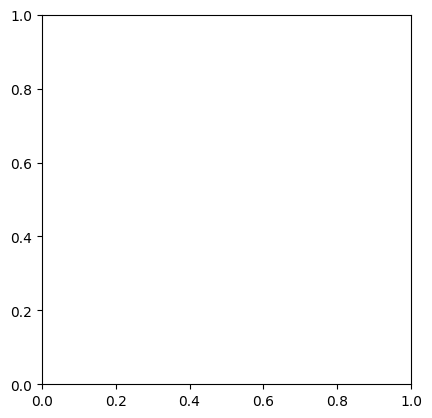

In [69]:
df_all_true.plot()